# Primal-Dual Learning of a 2D Wasserstein Geodesic

This notebook implements a primal-dual approach with:
- Source $\mu = \mathcal{N}(0, I)$ in $\mathbb{R}^2$.
- Target $\nu$ as a 3-mode Gaussian mixture on a circle of radius 5 with covariance $0.1I$.
- Primal variable $F: \mathbb{R}^2 \to \mathbb{R}^2$.
- Dual variable $\phi: (x,t) \mapsto \mathbb{R}$.


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [ ]:
import jax
import jax.numpy as jnp
from jax import random, grad, vmap
import optax
import flax.nnx as nnx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# jax.config.update("jax_enable_x64", True)

print("JAX version:", jax.__version__)

In [ ]:
# Hyperparameters
seed = 0
dim = 2
K = 2**12          # interior samples from mu x [0,1]
M = 2**16          # boundary samples for mu and nu
num_steps = 5000
iter_phi =   20    # inner maximization steps
lr_phi = 1e-4
lr_f = 1e-5
lambda_f_reg = 1e-2
max_speed = 1.0
ema_beta = 0.995
l2_eps = 1e-8

# Network sizes
width_f = 128
depth_f = 3
width_phi = 128
depth_phi = 5
num_time_freqs = 10

key = random.PRNGKey(seed)

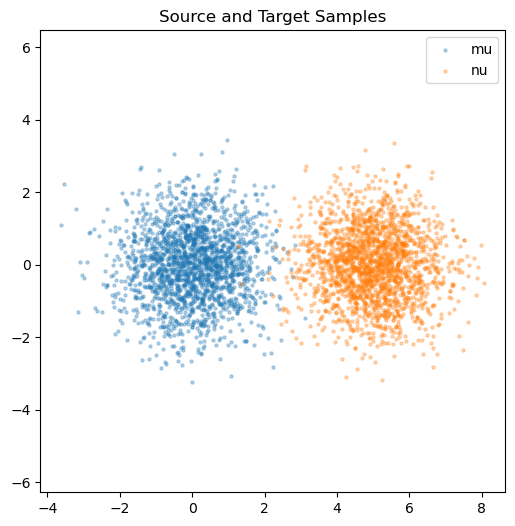

In [ ]:
# Distributions: sampling only (no analytic log-pdfs)
def sample_mu(key, n):
    return random.normal(key, shape=(n, 2))

def gmm_centers(radius=5.0):
    angles = jnp.array([0.0, 0.0 * jnp.pi / 3.0, 0.0 * jnp.pi / 3.0])
    return jnp.stack([radius * jnp.cos(angles), radius * jnp.sin(angles)], axis=-1)

def sample_nu(key, n, radius=5.0, cov_scale=1):
    k_idx, k_noise = random.split(key)
    centers = gmm_centers(radius)
    comp = random.randint(k_idx, shape=(n,), minval=0, maxval=3)
    means = centers[comp]
    noise = jnp.sqrt(cov_scale) * random.normal(k_noise, shape=(n, 2))
    return means + noise

def sample_interior(key, n):
    k_z, k_t = random.split(key)
    z = sample_mu(k_z, n)
    t = random.uniform(k_t, shape=(n,), minval=0.0, maxval=1.0)
    return z, t

# Quick sanity plot
k1, k2 = random.split(key)
x_mu = sample_mu(k1, 2000)
x_nu = sample_nu(k2, 2000)

plt.figure(figsize=(6, 6))
plt.scatter(x_mu[:, 0], x_mu[:, 1], s=5, alpha=0.3, label='mu')
plt.scatter(x_nu[:, 0], x_nu[:, 1], s=5, alpha=0.3, label='nu')
plt.axis('equal')
plt.legend()
plt.title('Source and Target Samples')
plt.show()

In [ ]:
# Networks
class MLP(nnx.Module):
    def __init__(self, din= 2, width = 64, depth=2, dout=2, rngs = nnx.Rngs(0)):
        self.layers = []
        in_dim = din
        for _ in range(depth):
            self.layers.append(nnx.Linear(in_dim, width, rngs=rngs,kernel_init=nnx.initializers.xavier_normal()))
            in_dim = width
        self.out = nnx.Linear(in_dim, dout, rngs=rngs,kernel_init = nnx.initializers.xavier_normal())

    def __call__(self, x):
        h = x
        for layer in self.layers:
            h = jax.nn.tanh(layer(h))
        return self.out(h)

def time_embedding(t,num_freqs = 8,rngs: nnx.Rngs = nnx.Rngs(0)):
    # t shape: (..., 1)
    
    freqs = jnp.linspace(1.0, 20.0, num_freqs)[None,:]
    phases = random.uniform(rngs(), shape=(num_freqs,), minval=0.0, maxval=2.0 * jnp.pi)[None,:]

    t = jnp.asarray(t)
    if t.ndim == 0:
        t = t[None, None]
    elif t.ndim == 1:
        t = t[:, None]
    elif t.ndim == 2 and t.shape[-1] == 1:
        pass
    else:
        raise ValueError(f"Expected t shape scalar, (B,), or (B,1), got {t.shape}")

    wt = t * freqs[None, :]
    emb = jnp.concatenate([t, jnp.sin(wt + phases[None,:])/freqs[None,:]], axis=-1)
    return emb





class FNet(nnx.Module):
    def __init__(self, width, depth, max_speed, rngs: nnx.Rngs):
        self.max_speed = max_speed
        self.mlp = MLP(din=2, width=width, depth=depth, dout=2, rngs=rngs)

    def __call__(self, z):
        return self.mlp(z)
    

class TimeEmbedding(nnx.Module):
    def __init__(self, num_freqs, rngs: nnx.Rngs):
        self.freqs = nnx.Variable(jnp.linspace(1.0, 20.0, num_freqs))
        
        # Phases
        p_init = random.uniform(rngs(), shape=(num_freqs,), minval=0.0, maxval=2.0 * jnp.pi)
        self.phases = nnx.Variable(p_init)

    def __call__(self, t):
        # Ensure t is (B, 1) for broadcasting
        if t.ndim == 0:
            t = t[None, None]
        elif t.ndim == 1:
            t = t[:, None]
            
        # Broadcasting: (B, 1) * (1, F) -> (B, F)
        f = self.freqs[None, :]
        p = self.phases[None, :]
        
        emb = jnp.sin(t * f + p) / f
        return emb

class PhiNet(nnx.Module):
    def __init__(self, width, depth, num_freqs, rngs: nnx.Rngs):
        # self.time_embedding = TimeEmbedding(num_freqs, rngs)
        
        # Input dim = spatial (2) + temporal embedding (num_freqs)
        din = 2 + 1
        self.mlp = MLP(din=din, width=width, depth=depth, dout=1, rngs=rngs)

    def __call__(self, x, t):
        te = t#self.time_embedding(t)
        # Concatenate x (B, 2) and te (B, num_freqs)
        h = jnp.concatenate([x, te], axis=-1)
        return self.mlp(h).squeeze(-1)


class PhiNet_(nnx.Module):

    def __init__(self,d,width,depth,rngs:nnx.Rngs):

        # Build resnet blocks
        self.layers = []
        in_dim = d+1
        for _ in range(depth):
            self.layers.append(nnx.Linear(in_dim,width,rngs = rngs,kernel_init = nnx.initializers.xavier_normal()))
            in_dim = width
        self.vector = nnx.Param(random.normal(rngs(),shape = (width,)),rngs = rngs)
        # Parameters of quadratic form

        self.A = nnx.Param(random.normal(rngs(),shape=(d,d)),rngs = rngs)
        self.b = nnx.Param(jnp.zeros(d),rngs = rngs)
        self.c = nnx.Param(jnp.zeros(()),rngs = rngs)

    def __call__(self,x,t):
        h = jnp.concatenate([x, t], axis=-1)
        h = self.layers[0](h)
        for layer in self.layers[1:]:
            h_new = jax.nn.tanh(layer(h))+h
            h = h_new

        linear = h @ self.vector            # vector shape (width,)
        quad = 0.5 * jnp.einsum('bi,ij,bj->b', x, self.A, x)
        affine = x @ self.b + self.c
        out = linear + quad + affine
        return out

    


k_f, k_phi = random.split(key)
f_model = FNet(width=width_f, depth=depth_f, max_speed=max_speed, rngs=nnx.Rngs(k_f))
# phi_model = PhiNet(width=width_phi, depth=depth_phi, num_freqs=num_time_freqs, rngs=nnx.Rngs(k_phi))
phi_model = PhiNet_(dim,width_phi,depth_phi,rngs=nnx.Rngs(k_phi))
graphdef_phi, phi_params, phi_vars = nnx.split(phi_model, nnx.Param, nnx.Variable)
phi_emma = nnx.merge(graphdef_phi, phi_params, phi_vars)

scheduler_f = optax.exponential_decay(init_value=lr_f,transition_steps=500,decay_rate = 0.95)
opt_f = nnx.Optimizer(f_model, optax.adam(scheduler_f),wrt = nnx.Param)
scheduler_phi = optax.exponential_decay(init_value=lr_phi,transition_steps=500,decay_rate = 0.95)
opt_phi = nnx.Optimizer(phi_model, optax.adam(scheduler_phi),wrt=nnx.Param)

In [ ]:
# Objective pieces
def phi_scalar_from_xt(phi_net, xt):
    x = xt[:2]
    t_scalar = xt[2]
    return phi_net(x[None, :], jnp.array([[t_scalar]]) )[0]

def grad_xt_batch(phi_net, x_batch, t_batch):
    xt_batch = jnp.concatenate([x_batch, t_batch[:, None]], axis=-1)
    return vmap(lambda xt: grad(lambda xti: phi_scalar_from_xt(phi_net, xti))(xt))(xt_batch)

def interior_integrand_mixed_batch(phi_net, phi_emma_net, x_batch, t_batch):
    # Mixed derivatives with L2 coupling between two terms
    grad_xt_phi = grad_xt_batch(phi_net, x_batch, t_batch)
    # grad_xt_emma = grad_xt_batch(phi_emma_net, x_batch, t_batch)

    grad_phi_x = grad_xt_phi[:, :2]
    dphi_dt = grad_xt_phi[:, 2]
    # grad_emma_x = grad_xt_emma[:, :2]
    # dphi_emma_dt = grad_xt_emma[:, 2]

    # term_a = -dphi_dt - 0.5 * jnp.sum(grad_emma_x * grad_emma_x, axis=-1)
    # term_b = -dphi_emma_dt - 0.5 * jnp.sum(grad_phi_x * grad_phi_x, axis=-1)
    # mixed_l2 = jnp.sqrt(0.5 * (term_a * term_a + term_b * term_b) + l2_eps)
    # mixed_l2 = term_a+term_b
    return  -jnp.mean(dphi_dt+ jnp.sum(grad_phi_x*grad_phi_x,axis = -1))  # jnp.mean(term_a)+jnp.mean(term_b) #

def boundary_term(phi_net, z_mu, y_nu):
    phi_mu0 = phi_net(z_mu, jnp.zeros((z_mu.shape[0], 1)))
    phi_nu1 = phi_net(y_nu, jnp.ones((y_nu.shape[0], 1)))
    return jnp.mean(phi_nu1) - jnp.mean(phi_mu0)

def saddle_objective(phi_net, phi_emma_net, f_net, z_int, t_int, stop_f=False):
    v = f_net(z_int)
    if stop_f:
        v = jax.lax.stop_gradient(v)
    x_t = z_int + t_int[:, None] * v
    return interior_integrand_mixed_batch(phi_net, phi_emma_net, x_t, t_int)

def phi_loss(phi_net, phi_emma_net, f_net, z_int, t_int, z_mu, y_nu):
    # Max over phi == min of negative objective
    return -saddle_objective(phi_net, phi_emma_net, f_net, z_int, t_int, stop_f=True)-boundary_term(phi_net,z_mu,y_nu)

def f_loss(f_net, phi_net, z_int, t_int, z_mu, y_nu):
    # Min over F with small kinetic regularization for stability
    # F-update uses phi only (no phi_emma in objective for F)
    interior = saddle_objective(phi_net, phi_net, f_net, z_int, t_int, stop_f=False)
    v = f_net(z_int)
    reg = lambda_f_reg * jnp.mean(jnp.sum(v * v, axis=-1))
    return interior + reg

outer/F updates:   0%|          | 0/5000 [00:06<?, ?it/s, l_f=-26, l_phi=28.6]

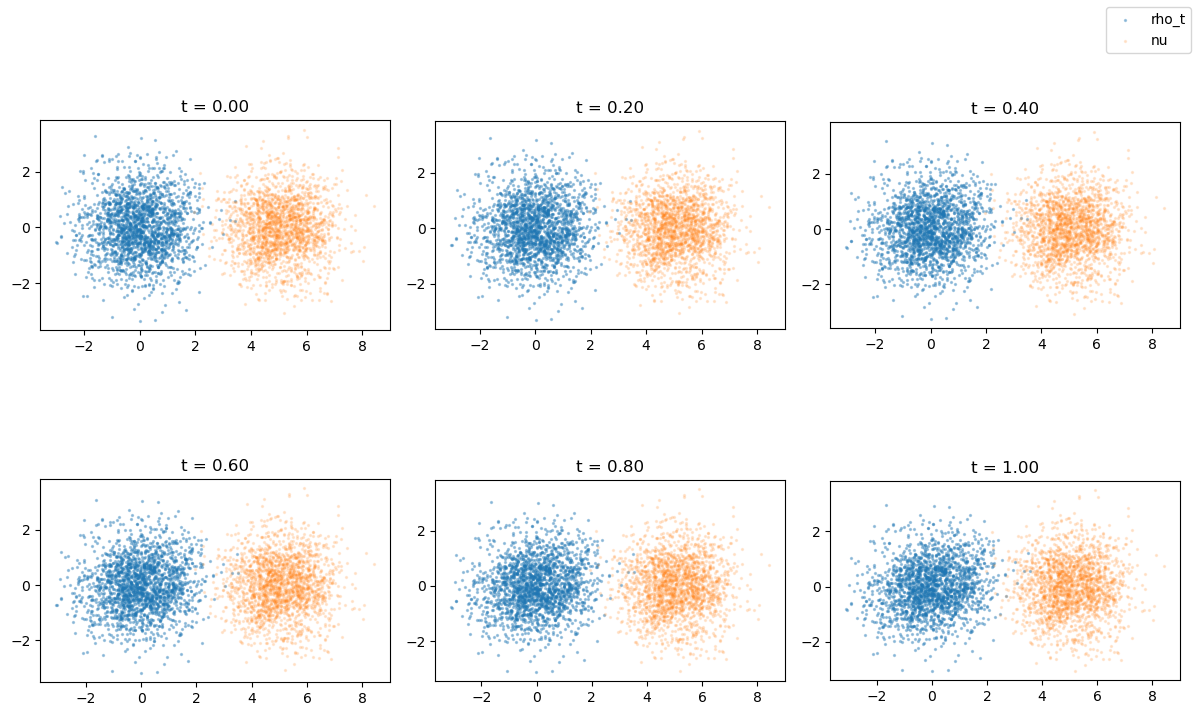

outer/F updates:   4%|▍         | 199/5000 [00:23<06:35, 12.13it/s, l_f=-13.7, l_phi=-76.2] 

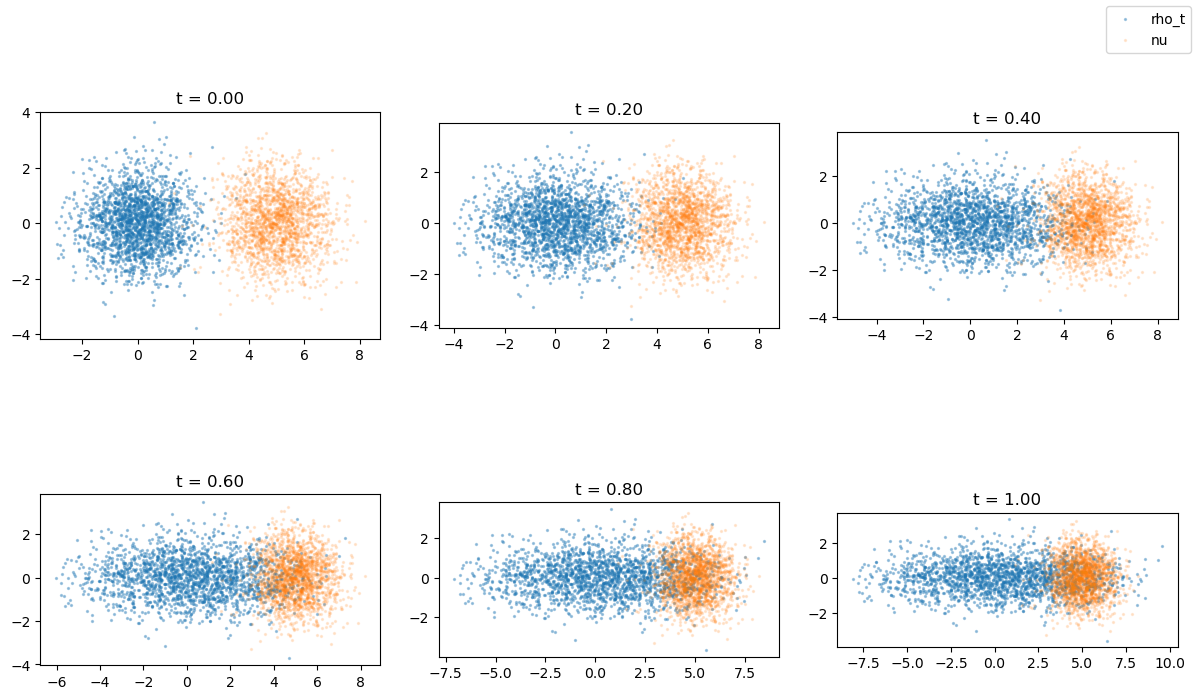

outer/F updates:   7%|▋         | 373/5000 [00:38<07:58,  9.67it/s, l_f=15.9, l_phi=-125]  


KeyboardInterrupt: 

In [ ]:
# Training loop: iter_phi inner ascent steps for phi, then one descent step for F
loss_phi_hist = []
loss_f_hist = []

def plot_geodesic_snapshots(f_net, rng_key, n_samples=2000, n_times=6):
    k_vis, k_target = random.split(rng_key)
    z_vis = sample_mu(k_vis, n_samples)
    target_vis = sample_nu(k_target, n_samples)
    v_vis = f_net(z_vis)
    ts = jnp.linspace(0.0, 1.0, n_times)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    for i, t in enumerate(ts):
        x_t = z_vis + t * v_vis
        ax = axes[i]
        ax.scatter(x_t[:, 0], x_t[:, 1], s=2, alpha=0.35, label='rho_t')
        ax.scatter(target_vis[:, 0], target_vis[:, 1], s=2, alpha=0.15, label='nu')
        ax.set_title(f't = {float(t):.2f}')
        ax.set_aspect('equal')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

def ema_update_phi(phi_net, phi_emma_net, beta):
    graphdef, phi_params, phi_vars = nnx.split(phi_net, nnx.Param, nnx.Variable)
    _, phi_emma_params, phi_emma_vars = nnx.split(phi_emma_net, nnx.Param, nnx.Variable)
    new_emma_params = jax.tree_util.tree_map(
        lambda e, p: beta * e + (1.0 - beta) * p,
        phi_emma_params,
        phi_params,
    )
    new_emma_vars = jax.tree_util.tree_map(
        lambda e, v: beta * e + (1.0 - beta) * v,
        phi_emma_vars,
        phi_vars,
    )
    updated_model = nnx.merge(graphdef, new_emma_params, new_emma_vars)
    _, new_state,new_vars = nnx.split(updated_model, nnx.Param, nnx.Variable)
    nnx.update(phi_emma_net, new_state, new_vars)

@nnx.jit
def phi_step(phi_net, phi_emma_net, f_net, phi_opt, z_int, t_int, z_mu, y_nu):
    l_phi, g_phi = nnx.value_and_grad(phi_loss,argnums=0)(phi_net, phi_emma_net, f_net, z_int, t_int, z_mu, y_nu)
    phi_opt.update(g_phi)
    return l_phi

@nnx.jit
def f_step(f_net, phi_net, f_opt, z_int, t_int, z_mu, y_nu):
    l_f, g_f = nnx.value_and_grad(f_loss, argnums=0)(f_net, phi_net, z_int, t_int, z_mu, y_nu)
    f_opt.update(g_f)
    return l_f

outer_bar = tqdm(range(num_steps), desc='outer/F updates')
for step in outer_bar:
    key, k_int, k_mu, k_nu = random.split(key, 4)
    z_int, t_int = sample_interior(k_int, K)
    z_mu = sample_mu(k_mu, M)
    y_nu = sample_nu(k_nu, M)

    inner_bar = tqdm(range(iter_phi), desc=f'inner/phi step={step}', leave=False)
    for _ in inner_bar:
        l_phi = phi_step(phi_model, phi_emma, f_model, opt_phi, z_int, t_int, z_mu, y_nu)
        inner_bar.set_postfix(l_phi=float(l_phi))
        

    l_f = f_step(f_model, phi_model, opt_f, z_int, t_int, z_mu, y_nu)
    ema_update_phi(phi_model, phi_emma, ema_beta)

    loss_phi_hist.append(float(l_phi))
    loss_f_hist.append(float(l_f))
    outer_bar.set_postfix(l_phi=float(l_phi), l_f=float(l_f))

    if step % 200 == 0:
        key, k_plot = random.split(key)
        plot_geodesic_snapshots(f_model, k_plot)

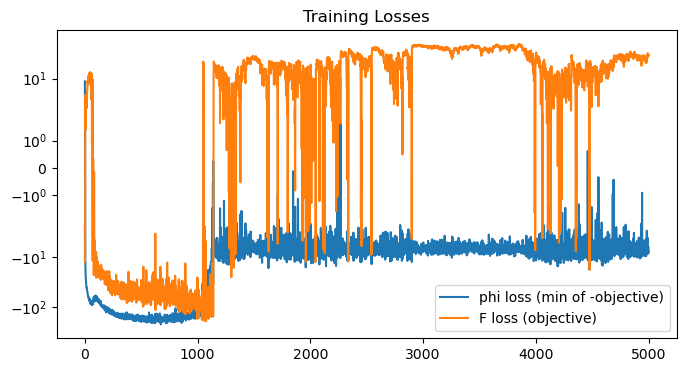

In [ ]:
# Loss curves
plt.figure(figsize=(8, 4))
plt.plot(loss_phi_hist, label='phi loss (min of -objective)')
plt.plot(loss_f_hist, label='F loss (objective)')
plt.yscale('symlog')
plt.legend()
plt.title('Training Losses')
plt.show()

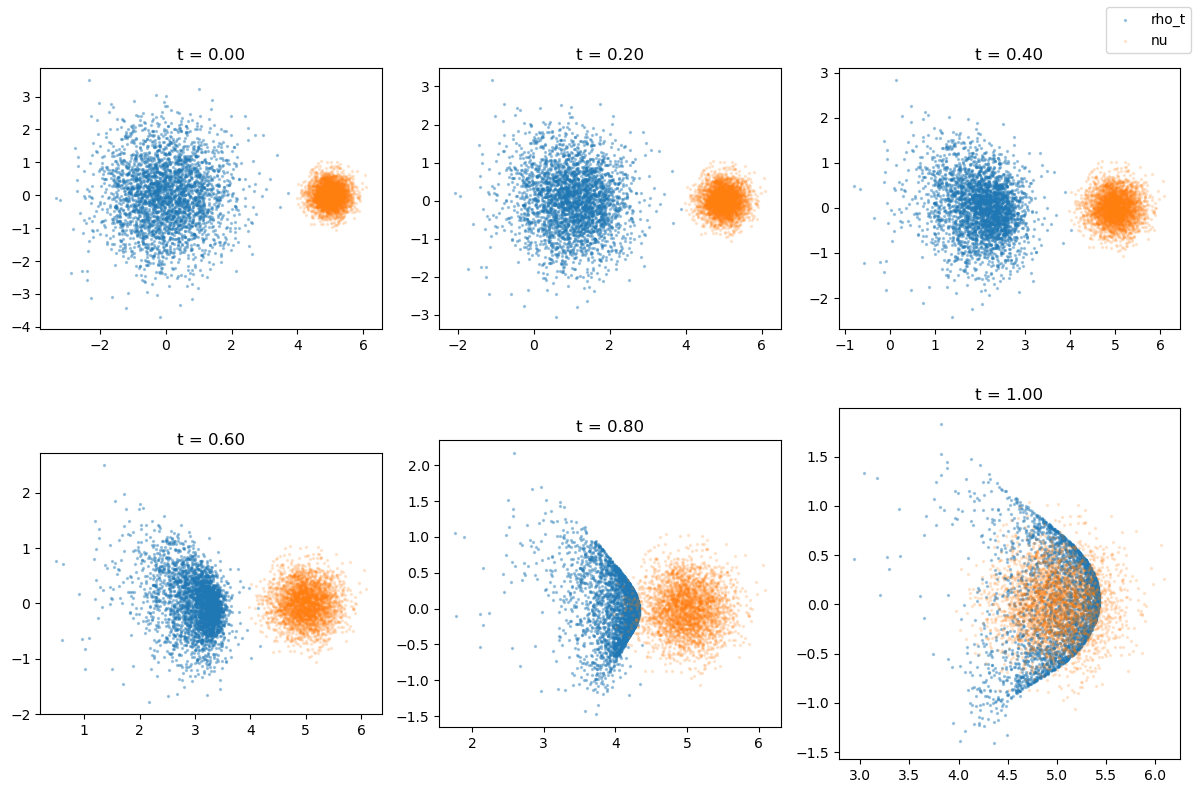

In [ ]:
# Visualize geodesic snapshots rho_t = (Id + tF)_# mu
key, k_vis, k_target = random.split(key, 3)
z_vis = sample_mu(k_vis, 3000)
target_vis = sample_nu(k_target, 3000)
v_vis = f_model(z_vis)

ts = jnp.linspace(0.0, 1.0, 6)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, t in enumerate(ts):
    x_t = z_vis + t * v_vis
    ax = axes[i]
    ax.scatter(x_t[:, 0], x_t[:, 1], s=2, alpha=0.35, label='rho_t')
    ax.scatter(target_vis[:, 0], target_vis[:, 1], s=2, alpha=0.15, label='nu')
    ax.set_title(f't = {float(t):.2f}')
    ax.set_aspect('equal')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()